In [19]:
import numpy as np
import matplotlib.pyplot as plt
import math as math

In [20]:
def physStep(t0, t1, a0, v0, x0, burning):
    x1 = 0
    v1 = 0
    a1 = 0
    
    lx = 1000
    lv = 1000
    la = 1000
    
    exhaustVelocity = 9154.2
    densityCoefficient = 0.076474252
    gravity = 32.174
    Tb = 288.15
    M0 = 191.5  # wet mass
    mdot = 3.51
    Cd = 0.5
    A = (4/12)**2*np.pi
    
    while (np.abs(lx-x1) > 1e-3) and (np.abs(lv-v1) > 1e-3):
        lx = x1
        lv = v1
        la = a1
        if burning:
            dv = ((exhaustVelocity*np.log(M0/(M0 - mdot*t1)) - gravity*t1 -
                  (exhaustVelocity*np.log(M0/(M0 - mdot*t0)) - gravity*t0)) -
                    (0.5*Cd*A*v1**2*atmosphericDensity(x1)/(M0 - mdot*t1)*(t1-t0)) +
                    (0.5*Cd*A*v0**2*atmosphericDensity(x0)/(M0 - mdot*t0)*(t1-t0)))
        else:
            dv = (- gravity*t1 + gravity*t0 -
                    (0.5*Cd*A*v1**2*atmosphericDensity(x1))/(M0 - mdot*t1)*(t1-t0) +
                    (0.5*Cd*A*v0**2*atmosphericDensity(x0))/(M0 - mdot*t0)*(t1-t0))
        da = a0 + dv / (t1-t0)
        v1 = v0 + dv
        dx = v1 * (t1-t0)
        x1 = x0 + dx
        a1 = a0 + da
    
    #print('here now')
    return [a1, v1, x1]

In [21]:
def atmosphericDensity(h):
#    Pb, Tb, Lb, hb
    Rb = 8.3145
    g = 9.80665
    M = 0.0289644
    if h < 36089:
        Pb = 1.2250*0.062428
        Tb = 288.15
        Lb = -0.0065
        hb = 0
    elif h < 65617:
        Pb = 0.36391*0.062428
        Tb = 216.65
        hb = 36089
        return Pb*math.exp(-g*M*(h - hb)/(Rb*Tb))
    elif h < 104987:
        Pb = 0.08803*0.062428
        Tb = 216.65
        Lb = 0.001
        hb = 65617
    elif h < 154199:
        Pb = 0.01322*0.062428
        Tb = 216.65
        Lb = 0.0028
        hb = 104987
    elif h < 167323:
        Pb = 0.00143*0.062428
        Tb = 270.65
        hb = 154199
        return Pb*math.exp(-g*M*(h - hb)/(Rb*Tb))
    elif h < 232940:
        Pb = 0.00086*0.062428
        Tb = 270.65
        Lb = -0.0028
        hb = 167323
    else:
        Pb = .000064*0.062428
        Tb = 214.65
        Lb = -0.002
        hb = 232940
    return Pb*(Tb/(Tb+Lb*(h - hb)))**(1 + g*M/(Rb*Lb))
print(atmosphericDensity(154199.48))

8.926663140349456e-05


Max Velocity = 1508.55031006 ft/s
Max Altitude = 44757.7166771 ft


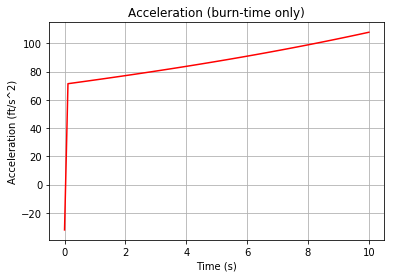

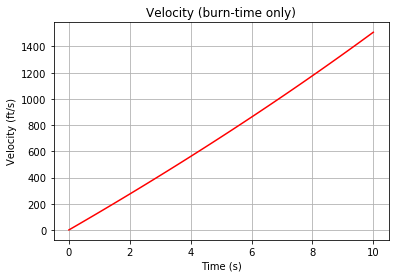

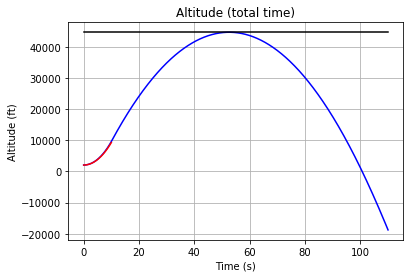

In [22]:
burnTime = 10  # seconds
totalTime = 110.0 # seconds
totalSteps = 1000
burnSteps = int(burnTime/totalTime*totalSteps)
coastSteps = totalSteps-burnSteps
burnTimeLinspace = np.linspace(0,burnTime,burnSteps)
totalTimeLinspace = np.linspace(0,totalTime,totalSteps)
acc = np.zeros([totalSteps]);
vel = np.zeros([totalSteps]);
pos = np.zeros([totalSteps]);

pos[0] = 2066;
acc[0] = -32.174;

for i in range(1,burnSteps):
    burningBool = True
    [acc[i], vel[i], pos[i]] = physStep((i-1)*burnTime/burnSteps,i*burnTime/burnSteps,acc[0],vel[i-1],pos[i-1], burningBool);


for i in range(burnSteps,totalSteps):
    burningBool = False
    [acc[i], vel[i], pos[i]] = physStep((i-1)*totalTime/coastSteps,i*totalTime/coastSteps,acc[0],vel[i-1],pos[i-1], burningBool);

print('Max Velocity =', np.max(vel), 'ft/s')
print('Max Altitude =', np.max(pos), 'ft')

plt.figure(1)
plt.grid()
plt.title('Acceleration (burn-time only)')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (ft/s^2)')
plt.plot(burnTimeLinspace,acc[0:burnSteps],'r')

plt.figure(2)
plt.grid()
plt.title('Velocity (burn-time only)')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (ft/s)')
plt.plot(burnTimeLinspace,vel[0:burnSteps],'r')

plt.figure(3)
plt.grid()
plt.title('Altitude (total time)')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (ft)')
plt.plot(totalTimeLinspace,pos,'b')
plt.plot(burnTimeLinspace,pos[0:burnSteps],'r')
plt.plot([0,totalTime],[np.max(pos),np.max(pos)], 'k')
plt.show()
